In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
import os
import sys
parent_dir = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(parent_dir)

from wordle import Wordle
from wordle import load_vocab


all_words = load_vocab(f'../corncob_caps.txt')
n_actions = len(all_words)


class DQN(nn.Module):
    channels_hidden = 16
    channels_out = 32
    def __init__(self, n_out):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(Wordle.n_channels, DQN.channels_hidden, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool2d((1,3), stride=1, padding=(0, 1))
        self.conv2 = nn.Conv2d(DQN.channels_hidden, DQN.channels_out, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d((1,2), stride=1, padding=(0, 1))
        self.fcin = 3072
        self.fc1 = nn.Linear(in_features=self.fcin, out_features=n_out)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, self.fcin)  # -1 for batch size inference
        x = nn.functional.relu(self.fc1(x))
        return x

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(policy_net, state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #print(f'{state.size() = }')
            #print(f'{state = }')
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor(
            [[random.randint(0, n_actions - 1)]],
            device=device,
            dtype=torch.long
        )

In [4]:
from typing import Union

def optimize_model() -> Union[None, float]:
    """ Return Huber loss """
    if len(memory) < BATCH_SIZE:
        return None
    #print('running model opt')
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_nest_states = [s for s in batch.next_state if s is not None]
    if not non_final_nest_states:
        return None
    non_final_next_states = torch.cat(non_final_nest_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return loss

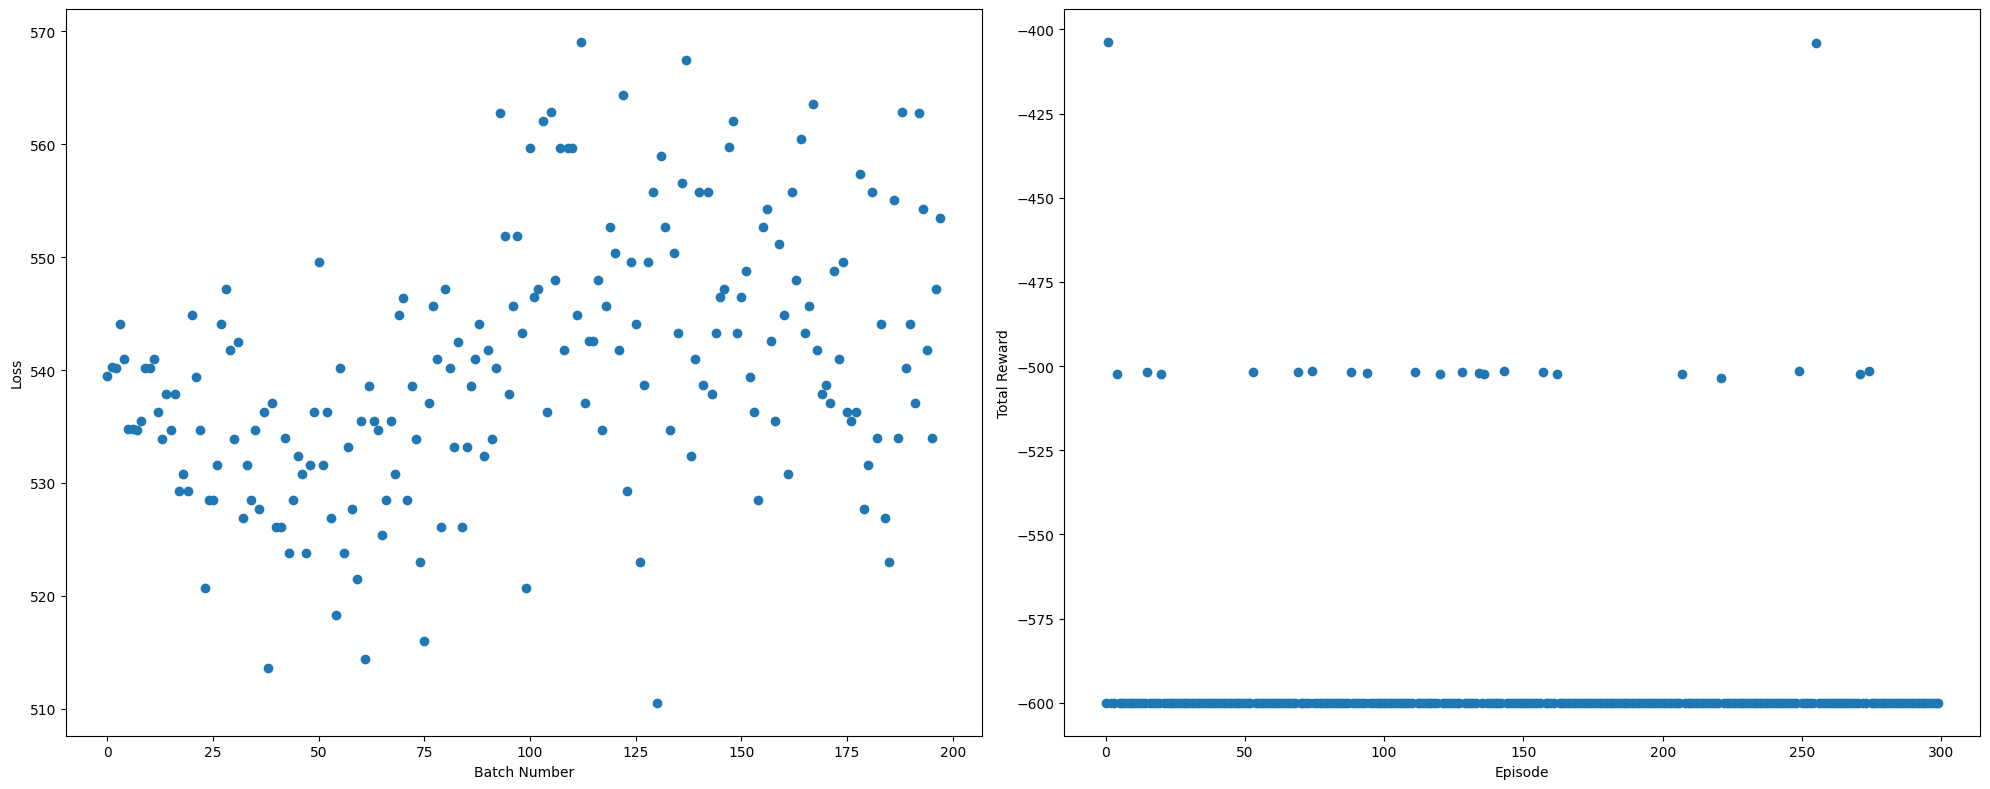

In [5]:
from collections import Counter
from collections import defaultdict


if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

def get_reward(state, guess_n, target_len, invalid: bool) -> float:
    #print(f'{guess_n = }')
    if invalid:
        return -100. * (Wordle.max_attempts - guess_n)
    reward = -10.
    #print(f'{state[Wordle.hint_channel, guess_n - 1] = }')
    for space in range(target_len):
        hint = state[Wordle.hint_channel, guess_n - 1, space]
        if hint == Wordle.char_not_used:
            reward += -1.
        elif hint == Wordle.correct:
            reward += 1.
        else: # hint == Wordle.char_elsewhere:
            reward += 0.
    #print(f'{reward / target_len = }')
    return reward / target_len

def plot_history(losses: list[float], batch_n: int, rewards: list[float], episode_n: int):
    plt.figure(0, figsize=(20, 8))
    plt.clf()
    plt.title(f'Episode {episode_n}')

    if batch_n:
        plt.delaxes()
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
        
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.scatter(tuple(range(batch_n)), losses)

        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Total Reward')
        ax2.scatter(tuple(range(episode_n + 1)), rewards)

        plt.tight_layout()

    else:
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.scatter(tuple(range(episode_n + 1)), rewards)

    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

class Checkpointer():
    def __init__(self, dir, model_file, optim_file):
        self.dir = dir
        self.model_file = os.path.join(self.dir, model_file)
        self.optim_file = os.path.join(self.dir, optim_file)
        self.best_loss = None

    def checkpoint(self, loss, model, optim) -> None:
        if self.best_loss is None or loss < self.best_loss:
            self.best_loss = loss
            model.eval()
            torch.save(model.state_dict(), self.model_file)
            torch.save(optim.state_dict(), self.optim_file)
            model.train()


class EarlyStopper():
    def __init__(self, min_delta=0, patience=0, start_episode=0):
        self.min_delta = min_delta
        self.patience = patience
        self.start_episode = start_episode
        self.episode_last_improved = 0
        self.best_loss = None
        self.stopped = False

    def stop(self, loss, episode_n) -> bool:
        if self.best_loss is None or loss <= self.loss - self.min_delta:
            self.loss = loss
            self.episode_last_improved = episode_n
            return False
        elif (
            episode_n > start_episode + self.patience
            and episode_n > sef.episode_last_improved + self.patience
        ):
            self.stopped = True
            return True
        else:
            return False


rewards = []
losses = []
batch_n = 0
checkpointer = Checkpointer('../checkpoints', 'model.pt', 'optim.pt')
checkpointer.checkpoint(None, policy_net, optimizer)
stopper = EarlyStopper(
    min_delta=0.0,
    patience=50,
    start_episode=200
)
for i_episode in range(num_episodes):
    #print(f'{i_episode = }')
    if stopper.stopped:
        print(f'Early stopping after {i_episode} episodes')
        break
    wordle = Wordle(all_words)
    #print(f'{wordle.target = }')
    #print(f'{wordle.target_len = }')
    state = wordle.state
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    #next_state = state
    status = Wordle.ongoing
    reward_total = 0
    while status == Wordle.ongoing:
        #print(f'state size in loop: {state.size()}')
        #print(f'state in loop: {state}')
        action = select_action(policy_net, state)
        invalid_guess = False
        try:
            next_state = wordle.guess(all_words[action])
            status = wordle.check_state()
        except ValueError:
            # "Should" maybe wordle.attempts_made += 1, but not used in reward anyway
            next_state = None
            status = Wordle.lost
            invalid_guess = True
        reward = get_reward(
            next_state,
            wordle.attempts_made,
            wordle.target_len,
            invalid=invalid_guess
        )
        if not invalid_guess:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        reward = torch.tensor([reward], device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        reward_total += reward
        state = next_state

        # Perform optimization on the policy network, checkpoint, early stopping
        loss = optimize_model()
        if loss:
            loss = float(loss)
            losses.append(loss)
            batch_n += 1
            checkpointer.checkpoint(loss, policy_net, optimizer)
        if stopper.stop(loss, i_episode):
            break

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if status != Wordle.ongoing:
            rewards.append(reward_total)
            #if i_episode % 50 == 0:
            plot_history(losses, batch_n, rewards, i_episode)

    


print('Complete')
plot_history(losses, batch_n, rewards, i_episode);
plt.ioff();

In [11]:
game = Wordle(all_words)
print(f'{game.target = }')
print(f'{game.target_len = }')
state = game.state
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
with torch.no_grad():
    action = policy_net(state).max(1).indices.view(1, 1)
    guess = all_words[action]
print(f'guessing: {all_words[action]}')
state = game.guess(guess)

game.target = 'PORNOGRAPHER'
game.target_len = 12
guessing: ARTEFACTS


ValueError: 

In [8]:
npn = DQN(n_actions)
npn.load_state_dict(torch.load('../checkpoints/model.pt'))

<All keys matched successfully>